# Linear modeling


The simplest model we can try is a linear model on the time and domain features extracted. That is, we assume that

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p,
$$

where:

- $y$: target (the wear on the milling bit)
- $x_1, x_2, \dots, x_p$: predictors (time and domain features extracted from the signal)
- $\beta_0$: Intercept
- $\beta_1, \beta_2, \dots, \beta_p$: coefficients for the predictors

using regression we can estimate parameters $\beta_0, \beta_2, \dots, \beta_p$.


## Feature selection


Given the amount of features extracted is bigger than the amount of data points we will need to do some feature selection. We will use **Lasso** regression, a method that reduces the number of features the model uses for prediction by penalizing the absolute value of the regression cofficients $|\beta_i|$.


Lasso regression has a single hyperparameter $\lambda$ that controls the strength of the penalty. An optimal value of $\lambda$ is to be selected based on the performance of the model.


## Cross-validation


Cross-validation is a strategy that allows us to confidently validate the performance of a machine learning model by training and evaluating models on different subsets of our data, assesing the generalization capabilities of a model systematically.

The idea is to create many randomly chosen training-validation splits of the data (folds), usually on a 4:1 ratio, and use them to score models with different hyperparameters.

|                                          <img src="figures/cross-validation.png" alt="cv" width="600"/>                                          |
| :----------------------------------------------------------------------------------------------------------------------------------------------: |
| Visualizing cross-validation <br> (Source: **[MingYu (Ethen) Liu](http://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png)**) |


## Implementation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
features = pd.read_csv("../data/dashboard/c1/c1_features.csv")
wears = pd.read_csv("../data/raw/c1/c1_wear.csv")

In [3]:
X = features.values
y = wears.drop(columns=["cut"]).values

In [4]:
tscv = TimeSeriesSplit(n_splits=10)

In [5]:
pipeline = Pipeline([("scaler", StandardScaler()), ("lasso", Lasso(max_iter=100000))])

In [6]:
param_grid = {"lasso__alpha": np.logspace(-4, 2, 100)}

In [7]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    refit=True,
)

In [8]:
grid_search.fit(X, y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso', Lasso(max_iter=100000))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([1.00000000e-04, 1.14975700e-04, 1.32194115e-04, 1.51991108e-04,
       1.74752840e-04, 2.00923300e-04, 2.31012970e-04, 2.65608778e-04,
       3.05385551e...
       4.03701726e+00, 4.64158883e+00, 5.33669923e+00, 6.13590727e+00,
       7.05480231e+00, 8.11130831e+00, 9.32603347e+00, 1.07226722e+01,
       1.23284674e+01, 1.41747416e+01, 1.62975083e+01, 1.87381742e+01,
       2.15443469e+01, 2.47707636e+01, 2.84803587e+01, 3.27454916e+01,
       3.76493581e+01, 4.32876128e+01, 4.97702356e+01, 5.72236766e+01,
       6.57933225e+01, 7.56463328e+01, 8.69749003e+01, 1.00000000e+02])},
             scoring='neg_mean_squared_error', verbose=1)

In [9]:
print("Best Parameters = {}".format(grid_search.best_params_))

Best Parameters = {'lasso__alpha': 0.020092330025650477}


In [10]:
best_alpha = grid_search.best_params_["lasso__alpha"]
best_pipeline = grid_search.best_estimator_

print(f"Best alpha: {best_alpha}")

Best alpha: 0.020092330025650477


In [11]:
y_pred = best_pipeline.predict(X)

In [12]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [13]:
def plot_predictions(y_actual, y_pred):
    flute_labels = [f"Flute {i+1}" for i in range(y_actual.shape[1])]

    fig = plt.figure(figsize=(24, 9))

    for i in range(y_actual.shape[1]):
        mse = mean_squared_error(y_actual[:, i], y_pred[:, i])
        mape = mean_absolute_percentage_error(y_actual[:, i], y_pred[:, i]) * 100
        ax = fig.add_subplot(1, len(flute_labels), i + 1)
        ax.plot(
            range(len(y_actual)),
            y_actual[:, i],
            label="Actual wear",
            marker="o",
            linewidth=6.0,
        )
        ax.plot(
            range(len(y_pred)),
            y_pred[:, i],
            label="Predicted wear",
            marker="x",
            linewidth=2.0,
        )
        ax.set_title(flute_labels[i])
        ax.set_xlabel("Cut number", labelpad=15)
        ax.set_ylabel("Wear Measurement")
        ax.legend()
        ax.text(
            0.5,
            0.9,
            f"MSE: {mse:.4f}\nMAPE: {mape:.2f}%",
            ha="center",
            va="top",
            transform=ax.transAxes,
            fontsize=12,
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"),
        )

    plt.tight_layout(pad=3.0)
    plt.show()


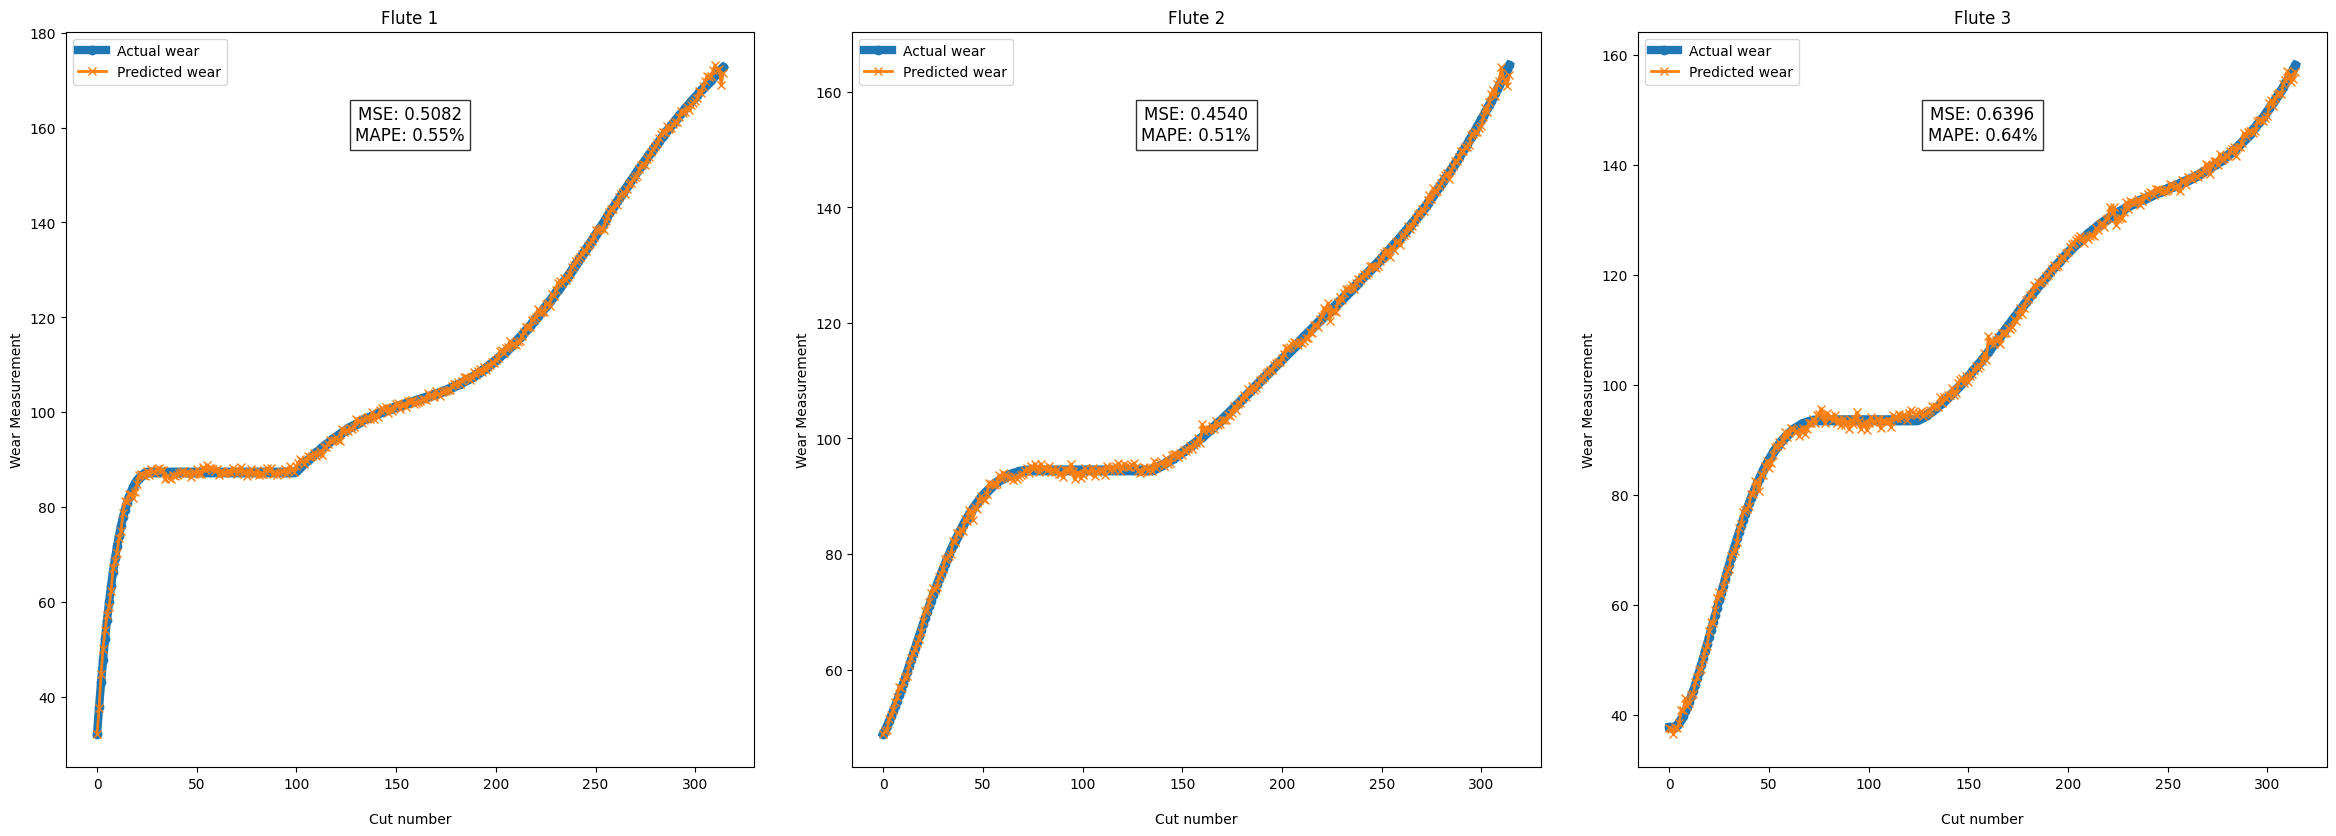

In [14]:
plot_predictions(y, y_pred)

In [15]:
best_lasso = best_pipeline.named_steps["lasso"]

In [16]:
(best_lasso.coef_ == 0)[0].sum()

286

In [17]:
sorted_features = [
    features.columns[np.argsort(-np.abs(coefs))] for coefs in best_lasso.coef_
]

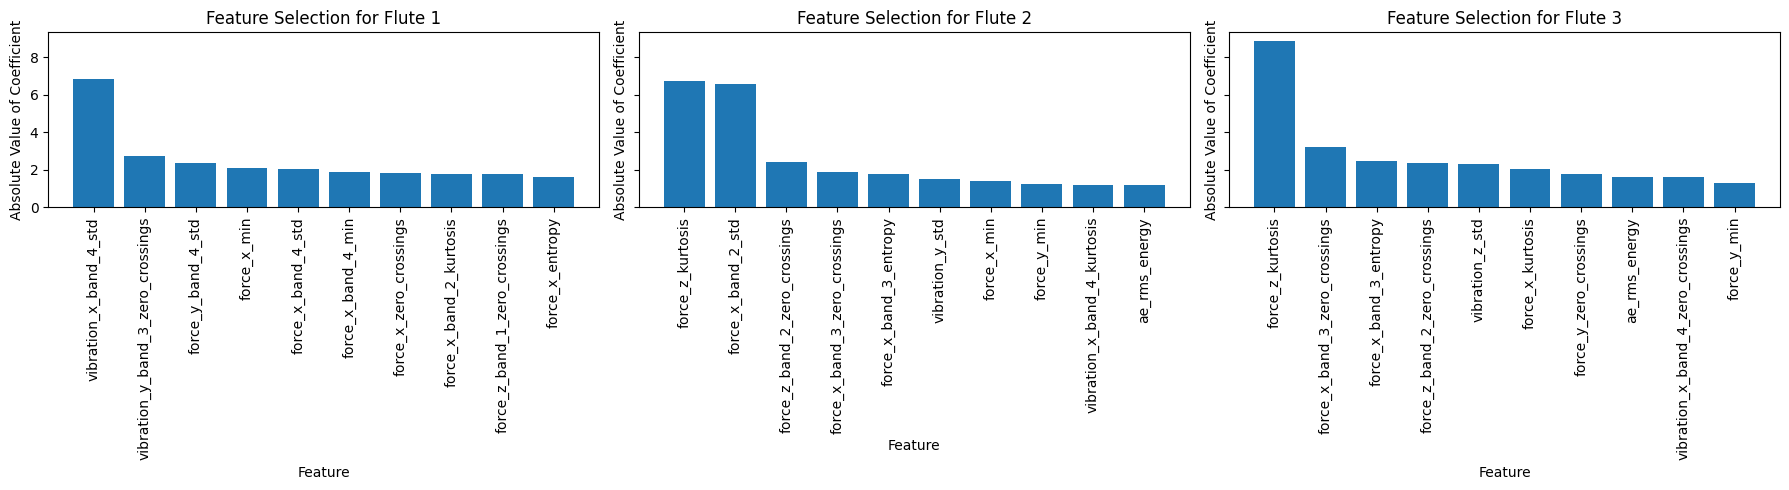

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, coefs in enumerate(best_lasso.coef_):
    ax = axes[i]
    ax.bar(sorted_features[i][:10], -np.sort(-np.abs(coefs))[:10])
    ax.set_title(f"Feature Selection for Flute {i + 1}")
    ax.set_xlabel("Feature")
    ax.set_ylabel("Absolute Value of Coefficient")
    ax.set_xticks(range(len(sorted_features[i][:10])))
    ax.set_xticklabels(sorted_features[i][:10], rotation=90)

plt.tight_layout()
plt.show()

## Testing on other datasets


In [19]:
features_c4 = pd.read_csv("../data/dashboard/c4/c4_features.csv")
wears_c4 = pd.read_csv("../data/raw/c4/c4_wear.csv")

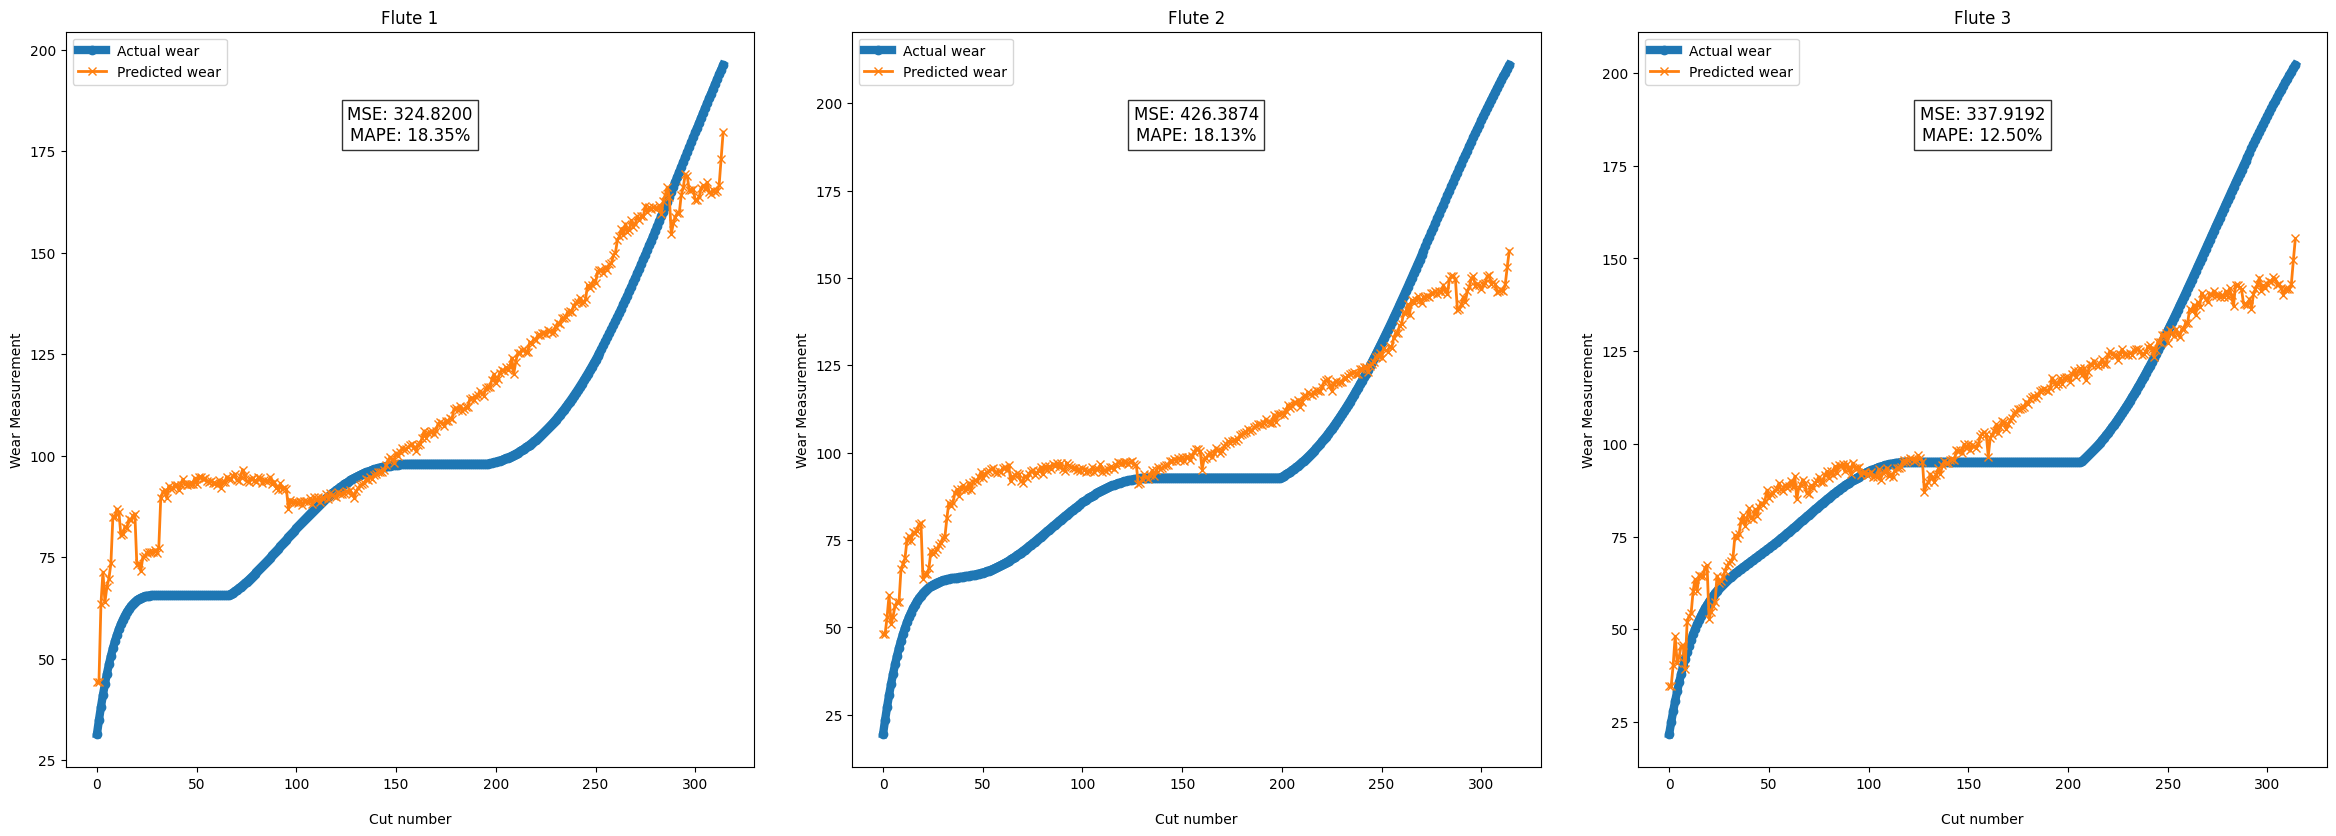

In [20]:
plot_predictions(
    wears_c4.drop(columns=["cut"]).values, best_pipeline.predict(features_c4.values)
)

In [21]:
features_c6 = pd.read_csv("../data/dashboard/c6/c6_features.csv")
wears_c6 = pd.read_csv("../data/raw/c6/c6_wear.csv")

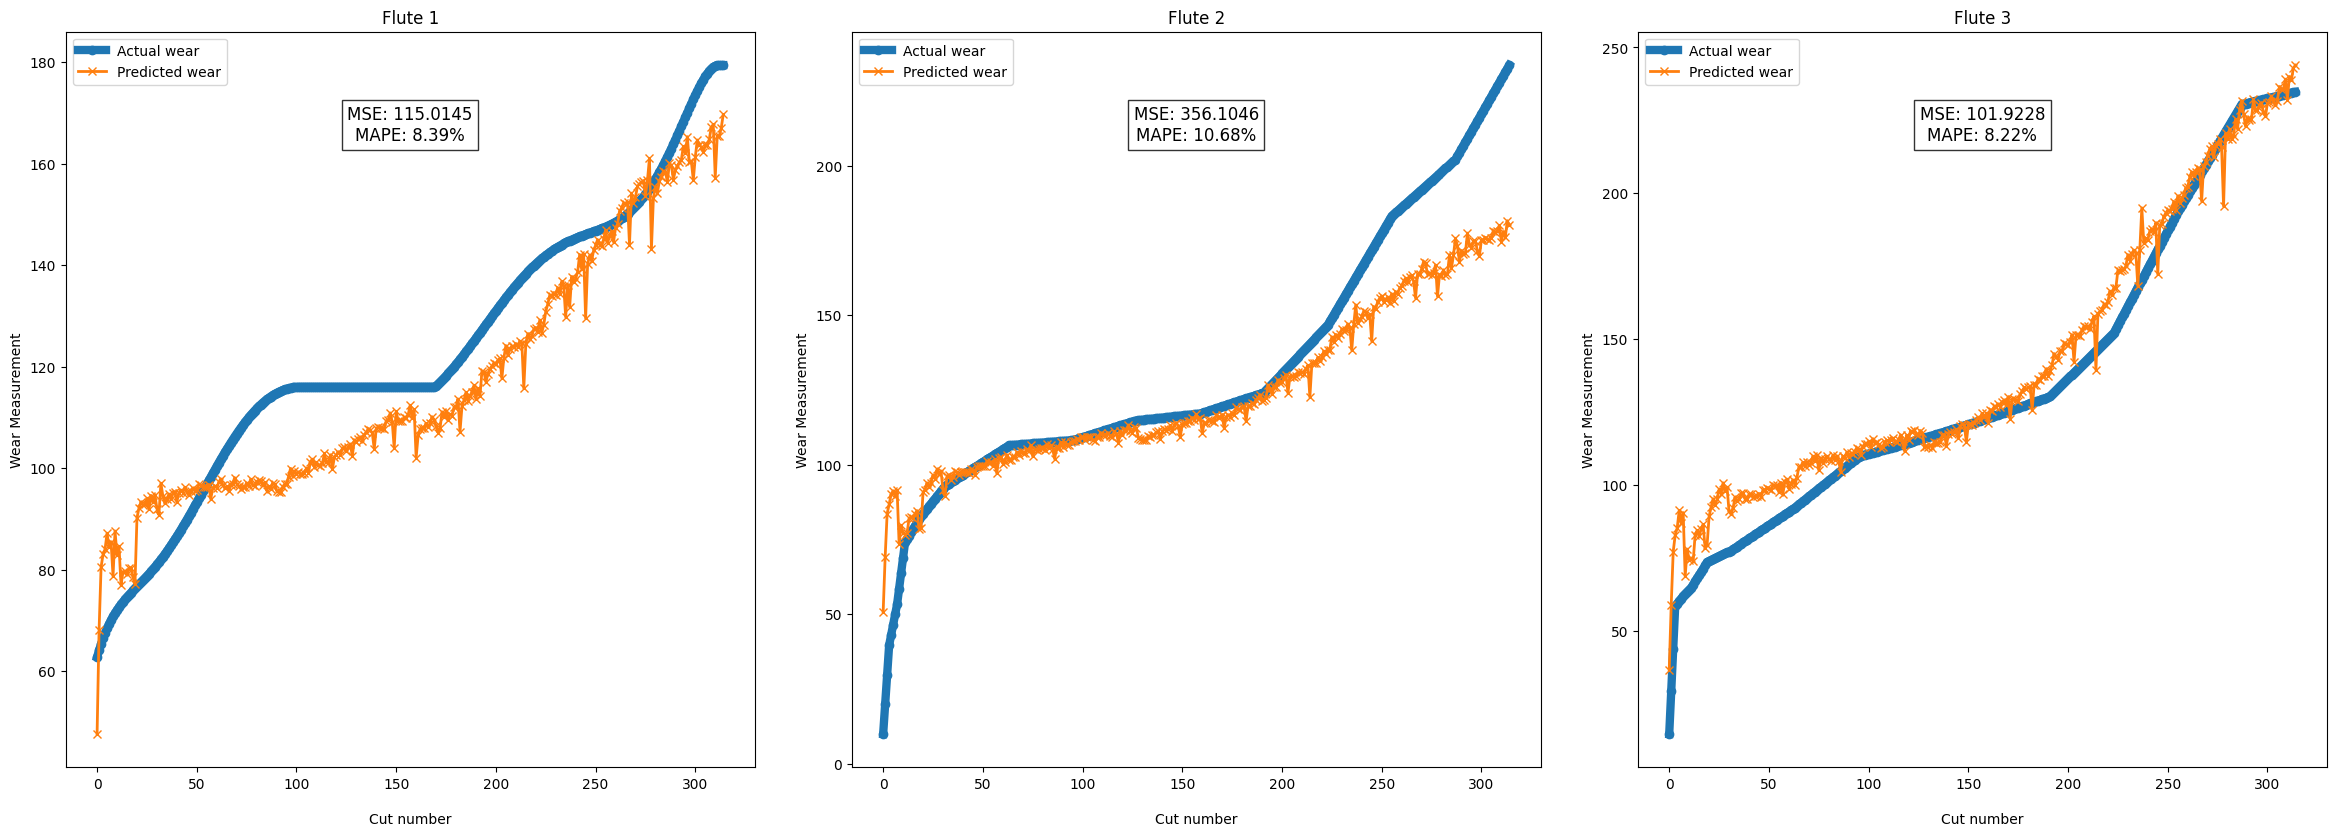

In [22]:
plot_predictions(
    wears_c6.drop(columns=["cut"]).values, best_pipeline.predict(features_c6.values)
)

We see that this model does not generalize very well. It is very overfitted to the dataset it was trained with.
